In [1]:
%matplotlib inline

In [2]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, accuracy_score, roc_auc_score
from sklearn.decomposition import TruncatedSVD, IncrementalPCA
from scipy.stats import chi2_contingency
from nltk.probability import FreqDist
from collections import defaultdict
from clpsych.store import Store
from clpsych.helpers import load_tokens

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse
import pandas as pd
import numpy as np
import codecs
import glob

In [3]:
def get_distribution(dataframe, key='title'):
    words = []
    for row in dataframe[key].apply(lambda x: x.split()).ravel():
        words.extend(row)
    return FreqDist(words)

def aggregate_posts(posts_with_users):
    users = defaultdict(list)
    labeled_users, bows = [], []

    for i, post_id, user_id in posts_with_users.itertuples():
        users[user_id].append(i)

    for user, posts in users.items():
        bows.append(np.sum(vocab[posts], axis=0))
        labeled_users.append(user > 0)

    bows = np.vstack(bows)
    labeled_users = np.array(labeled_users)
    
    return bows, labeled_users

In [4]:
train_classes = pd.DataFrame.from_csv('data/classes/sample_classes.txt')
dev_classes = pd.DataFrame.from_csv('data/classes/dev_classes.txt')
#sample_classes = pd.DataFrame.from_csv('data/classes/sample_classes.txt')

In [5]:
df = load_tokens(mask='data/tokens/tokens?.txt')

sent1 = pd.DataFrame.from_csv('data/features/sentiment_all.csv')
read1 = pd.DataFrame.from_csv('data/features/readability1.csv')
read2 = pd.DataFrame.from_csv('data/features/readability2.csv')

df = df\
    .merge(sent1[['post_id', 'user_id', 'text_sentiment', 'title_sentiment']], on='post_id')\
    .merge(read1[['post_id', 'text_smog', 'text_readability', 'title_readability']], on='post_id')\
    .merge(read2[['post_id', 'title_smog']], on='post_id')

In [6]:
# clear unused variables
%reset_selective sent1
%reset_selective read1
%reset_selective read2

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y
Once deleted, variables cannot be recovered. Proceed (y/[n])?  y
Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [7]:
labeled_docs = df.merge(train_classes, on='post_id').replace(np.nan, '', regex=True)
test_docs = df.merge(dev_classes, on='post_id').replace(np.nan, '', regex=True)

In [8]:
labeled_docs['text_features'] = labeled_docs[['title', 'doc']].apply(lambda x: ' '.join(x), axis=1)
test_docs['text_features'] = test_docs[['title', 'doc']].apply(lambda x: ' '.join(x), axis=1)

In [9]:
# clear out the big dataframe -- now we only need the subsets
%reset_selective df

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


# Classification

In [29]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

vectorizer = CountVectorizer(
    tokenizer=lambda x: x.split(), 
    stop_words='english', 
    decode_error='ignore', 
    min_df=40
)

transformer = TfidfTransformer()

In [30]:
vectorizer.fit(labeled_docs.text_features)
vocab = vectorizer.transform(labeled_docs.text_features)
transformer.fit(vocab)
vocab = transformer.transform(vocab)
test = transformer.transform(vectorizer.transform(test_docs.text_features))
#test = vectorizer.transform(test_docs.title)

In [31]:
#svd = TruncatedSVD(n_components=300, algorithm='arpack')
#svd.fit(vocab)

In [13]:
#vocab = svd.transform(vocab)
#test = svd.transform(test)

In [14]:
%reset_selective svd
%reset_selective vectorizer
%reset_selective transformer

Once deleted, variables cannot be recovered. Proceed (y/[n])?  n
Nothing done.
Once deleted, variables cannot be recovered. Proceed (y/[n])?  n
Nothing done.
Once deleted, variables cannot be recovered. Proceed (y/[n])?  n
Nothing done.


In [32]:
features = ['text_sentiment', 'title_sentiment', 'text_readability', 'title_readability', 'text_smog', 'title_smog']

X_train = labeled_docs[features].as_matrix()
y_train = labeled_docs['class'].as_matrix().astype('float')

X_test = test_docs[features].as_matrix()
y_test = test_docs['class'].as_matrix().astype('float')

In [16]:
# clear out some additional memory
%reset_selective labeled_docs
%reset_selective test_docs

Once deleted, variables cannot be recovered. Proceed (y/[n])?  n
Nothing done.
Once deleted, variables cannot be recovered. Proceed (y/[n])?  n
Nothing done.


In [33]:
# start with the smaller matri
#X_test = np.hstack((test, X_test))
#%reset_selective test
# hstack and then immediately try and reclaim space
#X_train = np.hstack((vocab, X_train))
#%reset_selective vocab

X_test = scipy.sparse.hstack((test, X_test))
X_train = scipy.sparse.hstack((vocab, X_train))

### Classify Each User

In [34]:
#clf = MultinomialNB()
#clf = RandomForestClassifier(n_estimators=50, max_depth=20)
clf = LogisticRegression()

In [35]:
#clf.fit(train_bows, train_labels)
clf.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [36]:
labels = clf.predict_proba(X_test)

In [37]:
accuracy_score(y_test, np.argmax(labels, axis=1))

0.71403683184371558

In [45]:
fpr, tpr, thresholds = roc_curve(y_test, labels[:, 1])

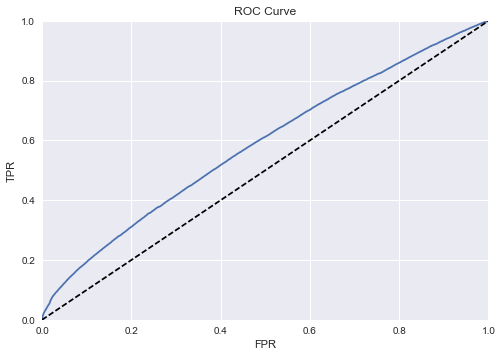

In [39]:
plt.plot(fpr, tpr)
plt.title('ROC Curve')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.plot([0, 1], [0, 1], 'k--')

In [40]:
roc_auc_score(y_test, labels[:, 1])

0.5860715776836416

### Aggregate the Posts by User

In [25]:
#posts_with_users = labeled_docs.merge(data[['post_id', 'user_id']], on='post_id')[['post_id', 'user_id']]
#train_bows, train_labels = aggregate_posts(labeled_docs)

In [26]:
#test_posts_with_users = test_docs.merge(data[['post_id', 'user_id']], on='post_id')[['post_id', 'user_id']]
#test_bows, test_labels = aggregate_posts(test_docs)

# Statistical Tests

In [27]:
# positives = labeled_docs[labeled_docs['class'] == False]
# controls = labeled_docs[labeled_docs['class'] == True]

# positive_dist = get_distribution(positives, key='title')
# controls_dist = get_distribution(controls, key='title')

In [28]:
# values = []
# for word, count in positive_dist.most_common():
#     if count < 50 or 1. * count / len(positives) > 0.4: continue
        
#     obs = np.array([
#         [positive_dist[word], positive_dist.N()-positive_dist[word]],
#         [controls_dist[word], controls_dist.N()-controls_dist[word]]
#     ])
#     g, p, _, _ = chi2_contingency(obs, lambda_='log-likelihood')
#     values.append((word, g))

# values = sorted(values, key=lambda x: x[1], reverse=True)